In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 32785088.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


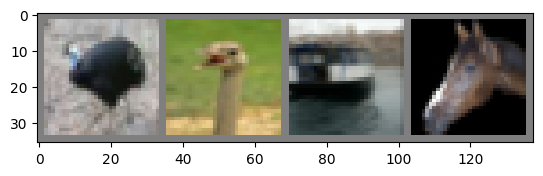

<generator object <genexpr> at 0x7eb340b02260>


In [4]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
#随机获取训练集图片
dataiter=iter(trainloader)
images,labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s") % classes[labels[j]] for j in range(4))

In [5]:
#构建卷积神经网络
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(3,6,5)#输入通道为3，输出通道为6，卷积核大小5*5
    self.pool=nn.MaxPool2d(2,2)#最大池化，池化核大小2*2，步长为2
    self.conv2=nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)
  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,16*5*5)#改变数据维度
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x
net=Net()

In [6]:
#定义损失函数和优化器
import torch.optim as optim
loss=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
#定义参数初始化
def init_kaiming_normal(m):
  if type(m)==nn.Conv2d:
    nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
    nn.init.zeros_(m.bias)
  elif type(m)==nn.Linear:
    nn.init.normal_(m.weight,mean=0,std=0.01)
    nn.init.zeros_(m.bias)
net.apply(init_kaiming_normal)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
#检查一下初始化是否执行
print(net.conv1.weight.data[0])
print(net.fc1.bias.data[0])

tensor([[[ 1.5169e-01,  7.3806e-02, -3.7919e-01,  3.2774e-01,  1.6802e-01],
         [ 2.9836e-01, -1.4518e-02,  3.3600e-01, -3.8301e-02, -4.7818e-01],
         [-7.6521e-03,  1.1820e-01,  1.1653e-01,  4.4707e-02,  3.0458e-02],
         [-6.5157e-02, -2.4537e-02,  2.2251e-01,  2.9243e-01, -3.1345e-02],
         [-4.4354e-03,  1.9361e-01, -2.1192e-02,  1.7505e-01, -1.2314e-01]],

        [[ 4.5815e-04,  2.9854e-01, -2.3392e-01,  1.0688e-01,  4.2733e-01],
         [ 9.3168e-02,  1.4042e-02,  4.1234e-01, -1.5342e-01,  1.3418e-01],
         [ 1.7086e-02, -1.0914e-01, -2.2457e-01,  1.1463e-01, -9.7831e-02],
         [ 3.7911e-02, -2.6655e-01, -8.2287e-02, -3.3651e-01, -1.1447e-02],
         [-1.3664e-01,  2.1775e-01, -1.1529e-01,  1.3480e-01, -2.0114e-01]],

        [[-2.6203e-01, -8.5919e-02,  4.8982e-02,  6.5229e-02,  2.0406e-03],
         [ 4.3093e-02,  2.8466e-02, -2.0263e-02,  1.0154e-01,  1.0504e-01],
         [ 2.4422e-02, -1.0444e-01, -4.1929e-02, -1.9295e-01,  9.0934e-02],
        

In [39]:
#训练网络
import time
start=time.time()
for epoch in range(2):
  running_loss=0.0
  for i,data in enumerate(trainloader,0):
    #获取输入数据
    inputs,labels=data
    #清空梯度缓存
    optimizer.zero_grad()
    outputs=net(inputs)
    l=loss(outputs,labels)
    l.backward()
    optimizer.step()
    #打印统计信息
    running_loss+=l.item()
    if i%2000==1999:
      print("[%d,%5d] loss:%.3f" % (epoch+1,i+1,running_loss/2000))
      running_loss=0.0
print('Finished Training! Total cost time: ',time.time()-start)

[1, 2000] loss:2.302
[1, 4000] loss:2.130
[1, 6000] loss:1.875
[1, 8000] loss:1.772
[1,10000] loss:1.685
[1,12000] loss:1.602
[2, 2000] loss:1.516
[2, 4000] loss:1.460
[2, 6000] loss:1.424
[2, 8000] loss:1.392
[2,10000] loss:1.377
[2,12000] loss:1.357
Finished Training! Total cost time:  199.8584122657776


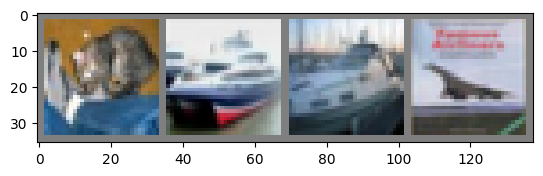

GroundTruth:    cat  ship  ship plane


In [40]:
#测试模型性能
dataiter=iter(testloader)
images,labels=next(dataiter)
#打印图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
preds=net(images)
_,predicted=torch.max(preds,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   bird  ship  ship plane


In [42]:
correct=0
total=0
with torch.no_grad():
  for data in testloader:
    images,labels=data
    preds=net(images)
    _,predicted=torch.max(preds.data,1)#返回每行的最大值及其对应标签，1表示按行求最大值
    total+=labels.shape[0]
    correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [46]:
#查看每个类别的分类准确率
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images,labels=data
    outputs=net(images)
    _,predicted=torch.max(outputs,1)
    c=(predicted==labels).squeeze()
    for i in range(4):
      label=labels[i]
      class_correct[label]+=c[i].item()
      class_total[label]+=1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 61 %
Accuracy of  bird : 44 %
Accuracy of   cat : 16 %
Accuracy of  deer : 50 %
Accuracy of   dog : 43 %
Accuracy of  frog : 71 %
Accuracy of horse : 59 %
Accuracy of  ship : 57 %
Accuracy of truck : 49 %


In [8]:
#train in GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
#训练网络
import time
start=time.time()
net.to(device)#转换到GPU上训练
for epoch in range(2):
  running_loss=0.0
  for i,data in enumerate(trainloader,0):
    #获取输入数据
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    #清空梯度缓存
    optimizer.zero_grad()
    outputs=net(inputs)
    l=loss(outputs,labels)
    l.backward()
    optimizer.step()
    #打印统计信息
    running_loss+=l.item()
    if i%2000==1999:
      print("[%d,%5d] loss:%.3f" % (epoch+1,i+1,running_loss/2000))
      running_loss=0.0
print('Finished Training! Total cost time: ',time.time()-start)

[1, 2000] loss:2.301
[1, 4000] loss:2.081
[1, 6000] loss:1.820
[1, 8000] loss:1.709
[1,10000] loss:1.622
[1,12000] loss:1.540
[2, 2000] loss:1.440
[2, 4000] loss:1.431
[2, 6000] loss:1.387
[2, 8000] loss:1.378
[2,10000] loss:1.335
[2,12000] loss:1.319
Finished Training! Total cost time:  115.20277118682861


In [13]:
#数据并行
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

input_size=5
output_size=2
batch_size=32
data_size=100
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
#构建随机数据集
class RandomDataset(Dataset):
  def __init__(self,size,length):
    self.len=length
    self.data=torch.randn(length,size)
  def __getitem__(self,index):
    return self.data[index]
  def __len__(self):
    return self.len
rand_loader=DataLoader(dataset=RandomDataset(input_size,data_size),batch_size=batch_size,shuffle=True)

In [16]:
data=iter(rand_loader)
next(data)

tensor([[ 0.6799,  0.1415, -0.4000, -0.4553, -1.6683],
        [ 0.0594,  2.2690, -0.6888, -0.2885, -0.7482],
        [-0.4095,  0.9770, -1.0557,  1.0946,  1.1666],
        [-1.8944, -1.2733,  0.4860, -0.4609,  0.2632],
        [-1.4793, -0.0633, -1.5631,  2.7006, -1.7622],
        [-0.7585, -2.4740, -2.1759, -0.3205, -0.4007],
        [ 1.0728, -0.2267,  0.3647, -2.1401,  0.9203],
        [ 0.9849, -0.0834,  1.1003,  1.6647,  2.3248],
        [-1.1938,  0.5504, -0.7382,  0.6806, -0.9585],
        [ 0.3600,  0.7683, -0.6938,  1.1319, -0.1718],
        [ 1.5909, -0.9496, -0.1596,  1.3991, -0.9108],
        [-0.1887,  0.8510, -0.2276, -1.7622,  0.1097],
        [-0.6114,  0.3665, -0.8554, -0.9146, -0.7328],
        [-1.4839,  0.1449,  0.7562,  0.8466, -1.9893],
        [-0.0478, -0.8483,  1.3342, -0.3563, -1.0067],
        [-0.1843, -0.2911, -0.6254, -0.4773,  0.1171],
        [ 0.3724, -0.2891,  0.1835,  1.9498,  0.3910],
        [ 0.1775,  1.0244, -1.0823, -1.1831, -0.7344],
        [ 

In [17]:
#构建简单网络模型
class Model(nn.Module):
  def __init__(self,input_size,output_size):
    super(Model,self).__init__()
    self.fc=nn.Linear(input_size,output_size)
  def forward(self,input):
    output=self.fc(input)
    return output

In [18]:
#创建模型与数据平行
model=Model(input_size,output_size)
if torch.cuda.device_count()>1:
  print("Let's use",torch.cuda.device_count(),"GPUS!")
  model=nn.DataParallel(model)
model.to(device)

Model(
  (fc): Linear(in_features=5, out_features=2, bias=True)
)

In [19]:
#进行训练
for data in rand_loader:
    input = data.to(device)
    output = model(input)
    print("Outside: input size", input.size(),
          "output_size", output.size())

Outside: input size torch.Size([32, 5]) output_size torch.Size([32, 2])
Outside: input size torch.Size([32, 5]) output_size torch.Size([32, 2])
Outside: input size torch.Size([32, 5]) output_size torch.Size([32, 2])
Outside: input size torch.Size([4, 5]) output_size torch.Size([4, 2])


如果仅仅只有1个GPU，则batch=32时，模型会得到输入输出的大小都是32，如果有多个GPU，则输入输出会被分到多个GPU上并行计算